In [2]:
# Import libraries

from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm, FISTA
from cil.optimisation.functions import Function, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox, LeastSquares, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise
from cil.processors import Slicer

import matplotlib.pyplot as plt

import numpy as np

import importlib

## Define classes

In [3]:
# Define SAGAGradientFunction, GradientDescent and ISTA


import sys
cil_path = '/u/s/cd902/GitHub/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
sys.path.append(cil_path + fun_path)
import SubsetSumFunction
importlib.reload(SubsetSumFunction)
from SubsetSumFunction import SumFunction, SAGAFunction, SGDFunction                                            

class GradientDescent(Algorithm):
    """
        Gradient Descent w/o Armijo rule
        Convergence guarantee: step-size < 2/L where L is the lipschitz constant
        of the gradient of the objective function
    """

    def  __init__(self, initial=None, objective_function=None, step_size=1, **kwargs):

        super(GradientDescent, self).__init__(**kwargs)

        self.set_up(initial=initial, objective_function=objective_function, step_size=step_size)



    def set_up(self, initial, objective_function, step_size):

        self.x = initial.copy()
        self.objective_function = objective_function
        self.x_update = initial.copy()
        self.step_size = step_size
        self.update_step_size = False        
        self.configured = True
        

    def update(self):
        '''Single iteration'''
        
        self.x_update = self.objective_function.gradient(self.x)
        
        self.x_update *= -self.step_size
        self.x += self.x_update

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))
                                 

class ISTA(Algorithm):
    """
        Iterative Shrinkage-Thresholding Algorithm
        Goal: minimize f + g with f smooth, g simple

        Convergence guarantee: 
        - f,g convex
        - step-size < 2/L where the gradient of f is L-Lipschitz

        See P. L. Combettes and V. A. L. Erie, 
        "Signal Recovery by Proximal Forward-Backward Splitting", 
        Multiscale Model. Simul., vol. 4, no. 4, pp. 1168–1200, 2005.
    """

    def  __init__(self, initial=None, f=None, g=None, step_size=1, **kwargs):

        super(ISTA, self).__init__(**kwargs)

        self.set_up(initial=initial, f=f, g=g, step_size=step_size)



    def set_up(self, initial, f, g, step_size):

        self.f = f
        self.g = g
        self.x = initial.copy()
        self.objective_function = SumFunction(f,g)
        self.x_update = initial.copy()
        self.step_size = step_size
        self.update_step_size = False        
        self.configured = True
        

    def update(self):
        '''Single iteration'''
        
        self.x_update = self.f.gradient(self.x)
        self.x_update *= -self.step_size
        self.x += self.x_update
        self.x = self.g.proximal(self.x, self.step_size)

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

## Define linear acceleration

In [37]:
class UniversalAcceleration(Algorithm):
    """
        'Accelerating variance-reduced stochastic gradient methods'
        Derek Driggs · Matthias J. Ehrhardt · Carola-Bibiane Schönlieb
        Mathematical Programming 2020


        Parameters
        ----------
        initial : DataContainer
                Starting point of the algorithm
        f : Function
            Differentiable function
        g : Function
            Convex function with *simple* proximal operator
        step_size : Function
            Function wich outputs the step-size at iteration k, gamma = step_size(k)
        momentum : Function
            Function wich outputs the momentum at iteration k, tau = momentum(k)
        kwargs: Keyword arguments
            Arguments from the base class :class:`.Algorithm`.
    """

    def  __init__(self, initial=None, f=None, g=None, step_size=None, momentum=None, **kwargs):

        super(UniversalAcceleration, self).__init__(**kwargs)

        self.set_up(initial=initial, f=f, g=g, step_size=step_size, momentum=momentum)


    def set_up(self, initial, f, g, step_size, momentum):

        self.f = f
        self.g = g
        self.x = initial.copy()
        self.grad_x = initial.copy()
        self.y = initial.copy()
        self.z = initial.copy()
        self.objective_function = SumFunction(f,g)
        self.step_size = step_size
        self.momentum = momentum
        self.configured = True

    def update(self):
        '''Single iteration'''

        # get current step-size
        gamma = self.step_size(self.iteration)
        # get current momentum  
        tau = self.momentum(self.iteration)

        # apply momentum, store in x
        self.z.axpby(tau, 1-tau, self.y, out=self.x)
        # compute the gradient at x, store in grad_x
        self.f.gradient(self.x, out=self.grad_x)
        # take the gradient step, store in z
        self.z.axpby(1, -gamma, self.grad_x, out=self.z)
        # take the proximal step, store in z
        self.z = self.g.proximal(self.z, gamma)
        # apply momentum, store in y
        self.z.axpby(tau, 1-tau, self.y, out=self.y)

    def update_objective(self):
        self.loss.append(self.objective_function(self.x))

## Create dataset

/home/cd902/miniconda3/envs/cilnew/lib/python3.9/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


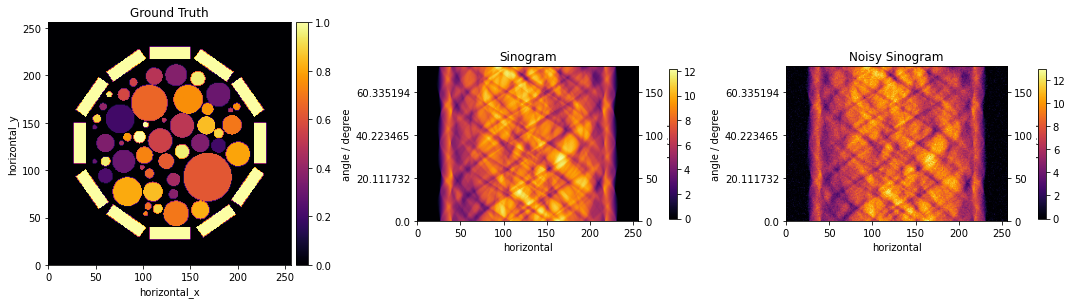

In [5]:
# Create dataset

# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Define number of subsets
n_subsets = 10

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino.array)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = LeastSquares(Ai, b = data_subset)
    f_subsets.append(fi)


# Define F and K
F = BlockFunction(*f_subsets)


# Run ISTA, FISTA, SAGA and F-SAGA


In [69]:
num_epochs = 100
lb = 0.01
g = lb * TotalVariation(lower=0)
initial = ig.allocate(0)

# ISTA 
f_gd = LeastSquares(A, noisy_sino)
step_size = 2*0.9 / f_gd.L
ista_tv = ISTA(initial=initial, f=f_gd, g=g,
                     step_size=step_size, update_objective_interval=1, 
                     max_iteration=1000)
ista_tv.run(num_epochs, verbose=0)

# FISTA
fista_tv = FISTA(initial=initial, f=f_gd, g=g,
                     update_objective_interval=1, 
                     max_iteration=1000)
fista_tv.run(num_epochs, verbose=0)

Initialised GradientOperator with C backend running with  8  threads
FISTA setting up
FISTA configured


In [70]:
scaled_lb = lb / n_subsets 
scaled_g = scaled_lb * TotalVariation(lower=0)
# SAGA
F_saga = SAGAFunction(F)
# admissible step-size is gamma = 1/ (3 max_i L_i)
step_size = 1 / (3*F_saga.Lmax)
F_saga.memory_reset()
saga_tv = ISTA(initial=initial, 
            f=F_saga,
            g=scaled_g,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
saga_tv.run(num_epochs * n_subsets, verbose=0)

Initialised GradientOperator with C backend running with  8  threads


In [71]:
# F-SAGA
F_saga = SAGAFunction(F)
F_saga.memory_reset()
# mini-batch size
b = 1
# step-size
def step_size_fun(k):
    return b**3 * (k + 4*n_subsets/b + 4) / (192 * n_subsets**2 * F_saga.Lmax)
# momentum
def momentum_fun(k):
    return b**3/ (96*n_subsets**1* F_saga.Lmax * step_size_fun(k))
fsaga_tv = UniversalAcceleration(initial=initial, 
            f=F_saga,
            g=scaled_g,
            step_size=step_size_fun, momentum=momentum_fun,
            update_objective_interval=n_subsets, 
            max_iteration=10000)
fsaga_tv.run(num_epochs * n_subsets, verbose=0)

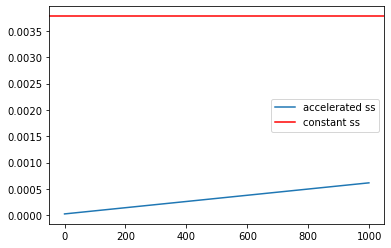

In [72]:
plt.figure(0)
kk = np.arange(num_epochs * n_subsets)
ss = step_size_fun(kk)
plt.plot(ss, label='accelerated ss')
plt.axhline(y=step_size, color='red', label='constant ss')
plt.legend()

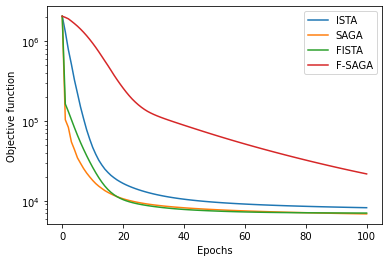

In [73]:
# compare results
plt.figure()
plt.semilogy(ista_tv.objective, label="ISTA")
plt.semilogy(saga_tv.objective, label="SAGA")
plt.semilogy(fista_tv.objective, label="FISTA")
plt.semilogy(fsaga_tv.objective, label="F-SAGA")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.show()

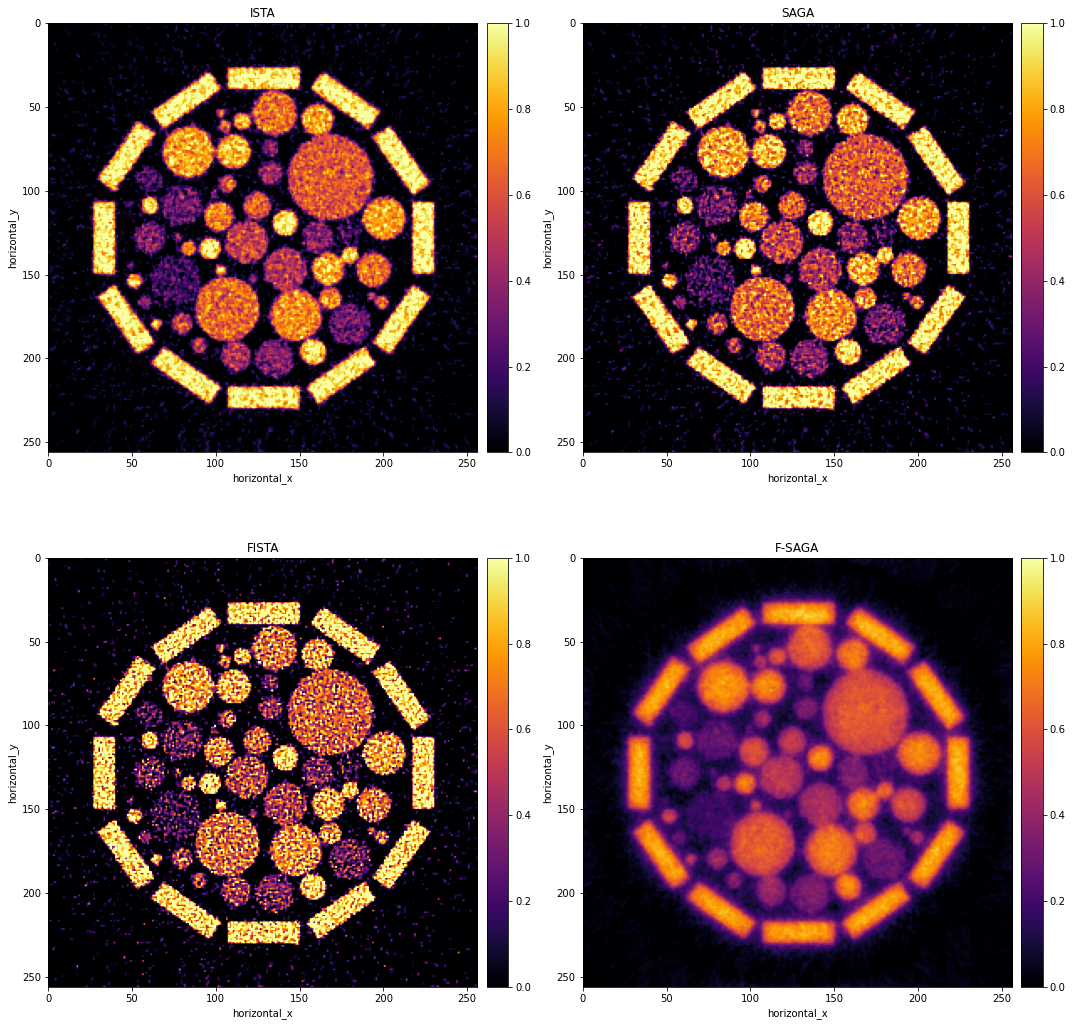

In [74]:
# Look at results
show2D([ista_tv.solution, saga_tv.solution, fista_tv.solution, fsaga_tv.solution], 
       origin="upper", 
       title=["ISTA","SAGA", "FISTA", "F-SAGA"],
       fix_range=(0,1), num_cols=2,
       cmap='inferno')